# Regularisation, Parameter Initialisation, Batchnorm, Optimisers

Create and compare different models (as described below).

Inspect the results by using tensorboard.


In [1]:
import tensorflow as tf
import datetime
import os

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Parameters


In [3]:
layersizes = [50,50,50,10]
batchsize = 32 
epochs = 20
learning_rate = 0.1

tensorboard_folder = "tb_logs_keras"
outdir = os.path.join(os.getcwd(), tensorboard_folder)

### Baseline Model

* No regularisation
* No Batch Norm
* Default parameter initialisation of Keras: What is the default?
* Sigmoid activation (last layer always softmax)
* SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop).

Now, create the baseline model. 

Possibly, add convenient naming to the layers so that you can more easily read the outputs in tensorboard. 

In [4]:
def baseline_model(layersizes, activation):
    """
    Provides an MLP model (using Sequential) with given layersizes. The last layer is a softmax layer.
    As activation function use sigmoid.
        
    Arguments:
    layersizes -- list of integers with the number of hidden units per layer. The last element is for MNIST 10.
    activation -- string specifying the activation function for the hidden layers to be used.
    
    """
    ### START YOUR CODE HERE ###

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    
    model.add(tf.keras.layers.Dense(units=layersizes[0],
                                    use_bias=True,
                                    activation=activation,
                                    name='Layer_{}'.format(0)))
    
    for i, ls in enumerate(layersizes[1:-1]):
        model.add(tf.keras.layers.Dense(units=ls,
                                        use_bias=True,
                                        activation=activation,
                                        name='Layer_{}'.format(i+1)))
    
    model.add(tf.keras.layers.Dense(units=layersizes[-1],
                                    use_bias=True,
                                    activation='softmax',
                                    name='Layer_{}'.format(len(layersizes)-1)))
    
    ### STOP YOUR CODE HERE ###

    return model

In [5]:
model = baseline_model(layersizes, 'sigmoid')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Layer_0 (Dense)              (None, 50)                39250     
_________________________________________________________________
Layer_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
Layer_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
Layer_3 (Dense)              (None, 10)                510       
Total params: 44,860
Trainable params: 44,860
Non-trainable params: 0
_________________________________________________________________


#### Run model

Use cross entropy as loss function.

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
run_name = "baseline"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)
# start tensorboard on command line with tensorboard -logs <path to outdir> 


### START YOUR CODE HERE ###
""""
Use this sparse_categorical_crossentropy loss function when there
are two or more label classes. We expect labels to be provided
as integers. If you want to provide labels using one-hot
representation, please use CategoricalCrossentropy loss.
"""
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

### STOP YOUR CODE HERE ###


Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3191 - accuracy: 0.1075 - val_loss: 2.2922 - val_accuracy: 0.1029
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2894 - accuracy: 0.1407 - val_loss: 2.2772 - val_accuracy: 0.2397
Epoch 3/20
1875/1875 [==============================] - 2s 955us/step - loss: 2.2722 - accuracy: 0.1988 - val_loss: 2.2414 - val_accuracy: 0.3137
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2212 - accuracy: 0.2713 - val_loss: 2.1045 - val_accuracy: 0.3244
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.0292 - accuracy: 0.3385 - val_loss: 1.7869 - val_accuracy: 0.3856
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.7242 - accuracy: 0.4279 - val_loss: 1.5358 - val_accuracy: 0.5311
Epoch 7/20
1875/1875 [==============================] - 2s 992us/step - loss: 1.4776 - accuracy: 0.5344 - val_loss: 1.2896 - val_accur

#### OUTPUTs

Provide here suitable plots and comments:

* Learning curves: train / test accuracy and loss


In [9]:
for key, value in history.history.items():
  print(key)

loss
accuracy
val_loss
val_accuracy


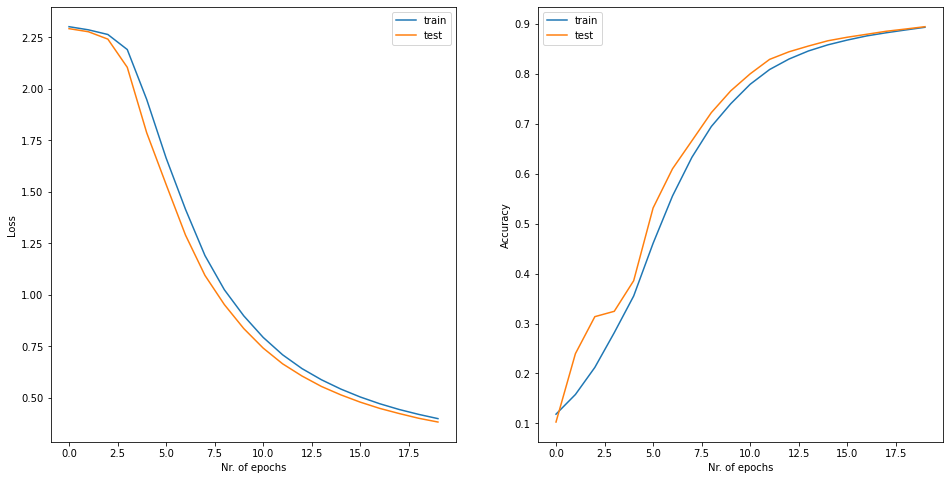

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##### Conclusion from the plots above
The loss starts with a rather high value and decreases significantly over time/number of epochs. A similar behaviour can be observed in the accuracy plot, the accuracy starts with a rather low value and increases significantly over time/number of epochs. These are very nice plots, which indicates perfectly, that our model does not suffer from high bias, nor high variance and is not fully converging, which indicates, that our model would highly benefit from longer training sessions/larger number of epochs. Still, it is expected, that the accuracy will not exceed 95% with this model. Let's stay curious and try to exploit further possibilites in the followoing sections.

### Parameter Initialisation

* No regularisation
* No Batch Norm
* __Parameter Initialisation: Compare GlorotNormal, Random Normal (mean 0, stdev 1), Zero, HeNormal__
* __Sigmoid Activation (last layer always softmax): Compare Sigmoid, ReLu__
* SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop).

Hence, for each of the 4 initializers train and test a model sigmoid and relu.

In [11]:
def model_param_init(layersizes, initializer, activation):
    """
    Provides an MLP model (using Sequential) with given layersizes. The last layer is a softmax layer.
    As activation function use sigmoid.
        
    Arguments:
    layersizes -- list of integers with the number of hidden units per layer. The last element is for MNIST 10.
    initializer -- weight initializer
    activation -- string specifying the activation function to be used.
    
    """
    ### START YOUR CODE HERE ###

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    
    model.add(tf.keras.layers.Dense(units=layersizes[0],
                                    kernel_initializer=initializer,
                                    bias_initializer=initializer,
                                    use_bias=True,
                                    activation=activation,
                                    name='Layer_{}'.format(0)))
    
    for i, ls in enumerate(layersizes[1:-1]):
        model.add(tf.keras.layers.Dense(units=ls,
                                    kernel_initializer=initializer,
                                    bias_initializer=initializer,
                                        use_bias=True,
                                        activation=activation,
                                        name='Layer_{}'.format(i+1)))
    
    model.add(tf.keras.layers.Dense(units=layersizes[-1],
                                    kernel_initializer=initializer,
                                    bias_initializer=initializer,
                                    use_bias=True,
                                    activation='softmax',
                                    name='Layer_{}'.format(len(layersizes)-1)))
    
    ### STOP YOUR CODE HERE ###

    return model

#### Run model

Run with the different settings.
Don't forget to configure the proper tensorboard callback.

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 2.3025 - accuracy: 0.1081 - val_loss: 2.3015 - val_accuracy: 0.1135
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3022 - accuracy: 0.1091 - val_loss: 2.3017 - val_accuracy: 0.1135
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3022 - accuracy: 0.1100 - val_loss: 2.3029 - val_accuracy: 0.1028
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3024 - accuracy: 0.1071 - val_loss: 2.3019 - val_accuracy: 0.1135
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3023 - accuracy: 0.1121 - val_loss: 2.3015 - val_accuracy: 0.1135
Epoch 6/20
1875/1875 [==============================] - 2s 968us/step - loss: 2.3020 - accuracy: 0.1124 - val_loss: 2.3013 - val_accuracy: 0.1010
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3014 - accuracy: 0.1141 - val_loss: 2.3019 - val_accurac

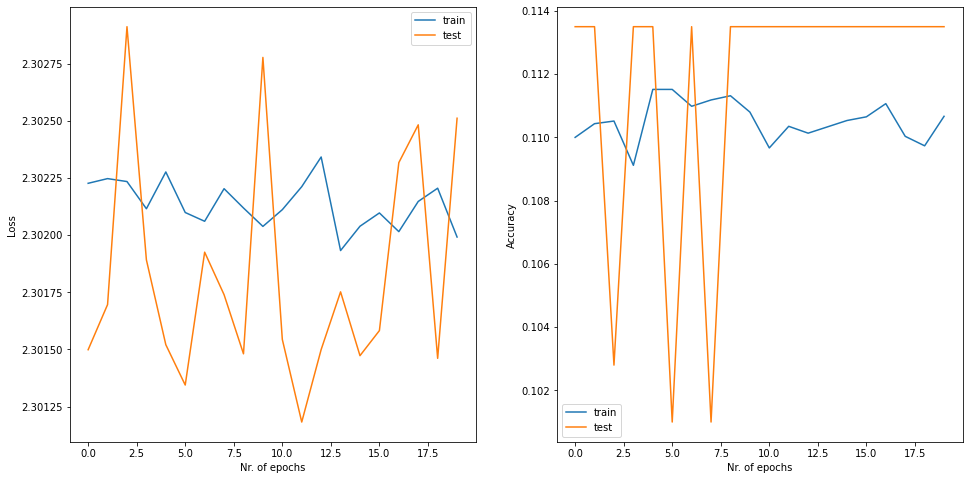

In [12]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_zeros_sigmoid"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.Zeros(), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3019 - accuracy: 0.1117 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3011 - accuracy: 0.1128 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3013 - accuracy: 0.1129 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 4/20
1875/1875 [==============================] - 2s 988us/step - loss: 2.3015 - accuracy: 0.1115 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3013 - accuracy: 0.1139 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3011 - accuracy: 0.1128 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3012 - accuracy: 0.1136 - val_loss: 2.3011 - val_accurac

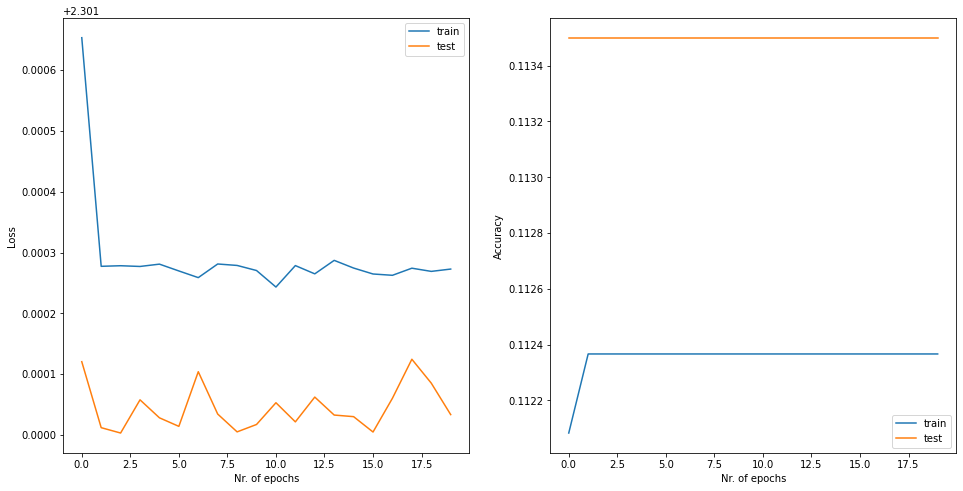

In [13]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_zeros_relu"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)


# fit model
model = model_param_init(layersizes, tf.keras.initializers.Zeros(), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 2.3104 - accuracy: 0.1092 - val_loss: 2.2950 - val_accuracy: 0.1135
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2928 - accuracy: 0.1275 - val_loss: 2.2844 - val_accuracy: 0.1664
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 2.2813 - accuracy: 0.1520 - val_loss: 2.2676 - val_accuracy: 0.1231
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2574 - accuracy: 0.2347 - val_loss: 2.2121 - val_accuracy: 0.3172
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1824 - accuracy: 0.3296 - val_loss: 2.0199 - val_accuracy: 0.4319
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 1.9420 - accuracy: 0.4273 - val_loss: 1.6983 - val_accuracy: 0.5088
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.6369 - accuracy: 0.4998 - val_loss: 1.4411 - val_accuracy:

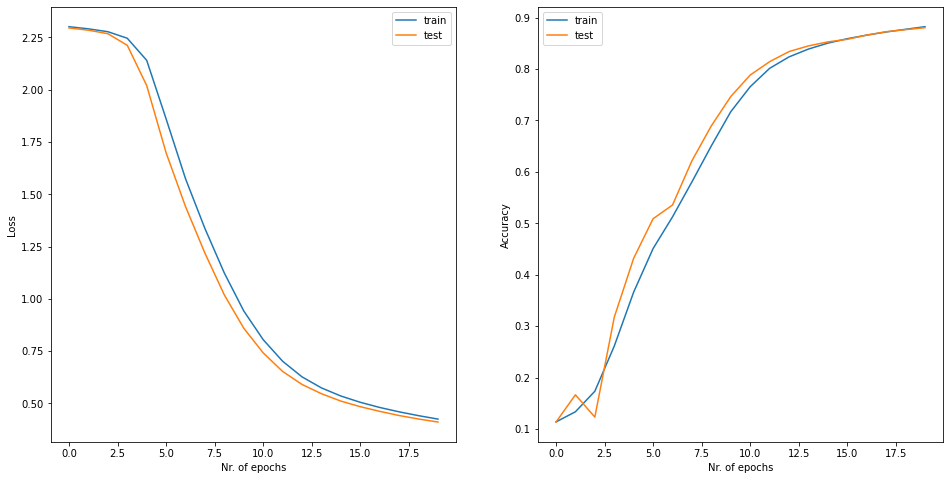

In [14]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_glorotnormal_sigmoid"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.3073 - accuracy: 0.5890 - val_loss: 0.3234 - val_accuracy: 0.9080
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3207 - accuracy: 0.9057 - val_loss: 0.2609 - val_accuracy: 0.9220
Epoch 3/20
1875/1875 [==============================] - 2s 973us/step - loss: 0.2501 - accuracy: 0.9271 - val_loss: 0.2079 - val_accuracy: 0.9364
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2101 - accuracy: 0.9380 - val_loss: 0.1841 - val_accuracy: 0.9440
Epoch 5/20
1875/1875 [==============================] - 2s 870us/step - loss: 0.1814 - accuracy: 0.9450 - val_loss: 0.1631 - val_accuracy: 0.9504
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1612 - accuracy: 0.9517 - val_loss: 0.1586 - val_accuracy: 0.9519
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1422 - accuracy: 0.9569 - val_loss: 0.1437 - val_accur

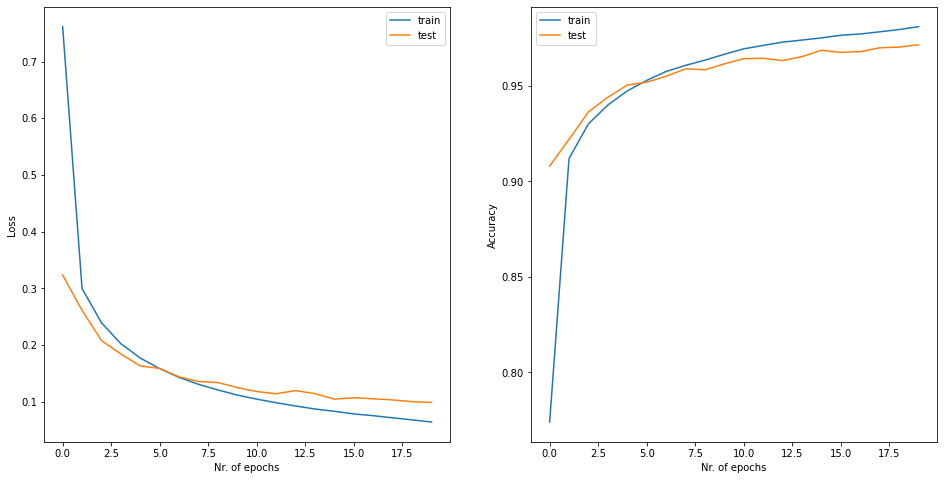

In [15]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_glorotnormal_relu"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 2.8564 - accuracy: 0.2027 - val_loss: 1.5992 - val_accuracy: 0.4726
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.5350 - accuracy: 0.4919 - val_loss: 1.2674 - val_accuracy: 0.5832
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.2482 - accuracy: 0.5904 - val_loss: 1.0833 - val_accuracy: 0.6537
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0779 - accuracy: 0.6471 - val_loss: 0.9628 - val_accuracy: 0.6938
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.9726 - accuracy: 0.6850 - val_loss: 0.8760 - val_accuracy: 0.7258
Epoch 6/20
1875/1875 [==============================] - 2s 894us/step - loss: 0.8811 - accuracy: 0.7162 - val_loss: 0.8101 - val_accuracy: 0.7515
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.8167 - accuracy: 0.7403 - val_loss: 0.7578 - val_accurac

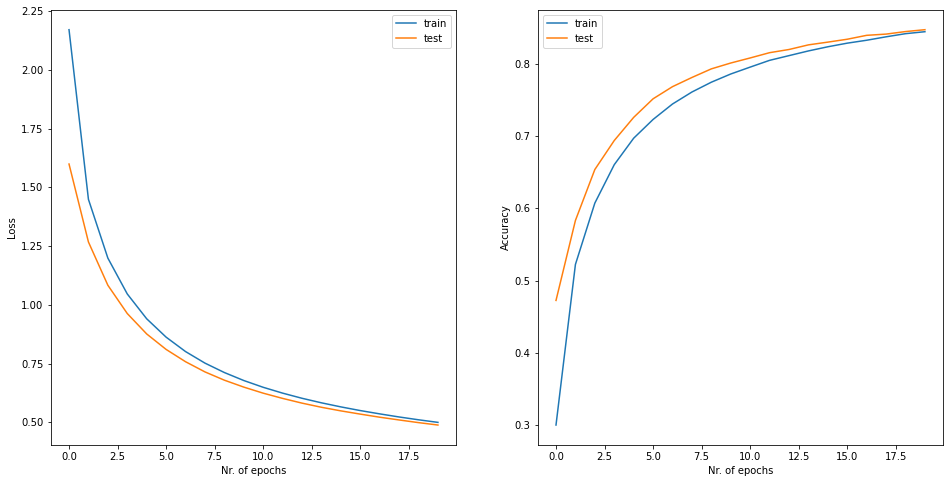

In [16]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_randnormal_sigmoid"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.RandomNormal(mean=0, stddev=1), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 29.1570 - accuracy: 0.1470 - val_loss: 2.2289 - val_accuracy: 0.1674
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2154 - accuracy: 0.1671 - val_loss: 2.1626 - val_accuracy: 0.1754
Epoch 3/20
1875/1875 [==============================] - 2s 993us/step - loss: 2.1385 - accuracy: 0.1881 - val_loss: 2.0985 - val_accuracy: 0.1987
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.0930 - accuracy: 0.1989 - val_loss: 2.0561 - val_accuracy: 0.2101
Epoch 5/20
1875/1875 [==============================] - 1s 799us/step - loss: 2.0660 - accuracy: 0.2043 - val_loss: 1.9952 - val_accuracy: 0.2195
Epoch 6/20
1875/1875 [==============================] - 2s 860us/step - loss: 1.9894 - accuracy: 0.2275 - val_loss: 1.9019 - val_accuracy: 0.2748
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.8757 - accuracy: 0.2836 - val_loss: 1.8370 - val_ac

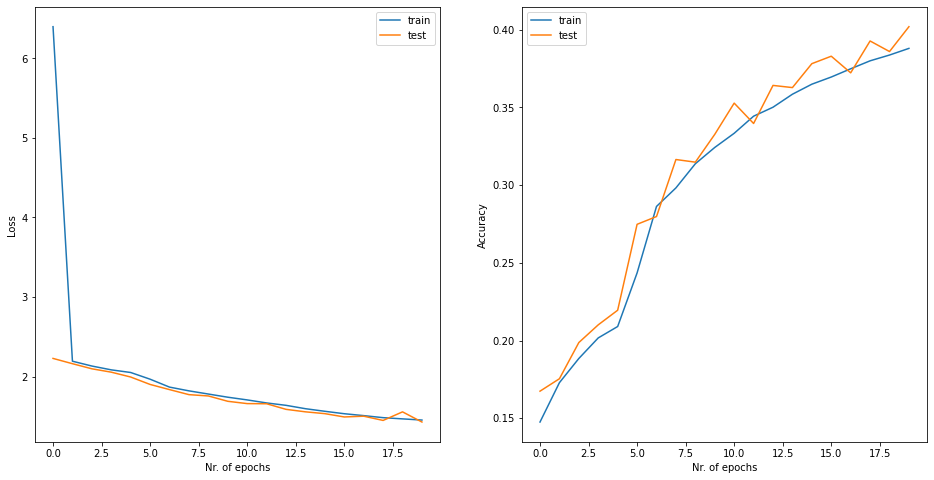

In [17]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_randnormal_relu"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.RandomNormal(mean=0, stddev=1), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3316 - accuracy: 0.1184 - val_loss: 2.2747 - val_accuracy: 0.2074
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2636 - accuracy: 0.2098 - val_loss: 2.2099 - val_accuracy: 0.3619
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1724 - accuracy: 0.3743 - val_loss: 1.9882 - val_accuracy: 0.4353
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.8957 - accuracy: 0.4403 - val_loss: 1.5972 - val_accuracy: 0.5043
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.5107 - accuracy: 0.5319 - val_loss: 1.2920 - val_accuracy: 0.6038
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.2306 - accuracy: 0.6346 - val_loss: 1.0734 - val_accuracy: 0.7065
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0198 - accuracy: 0.7187 - val_loss: 0.8942 - val_accuracy:

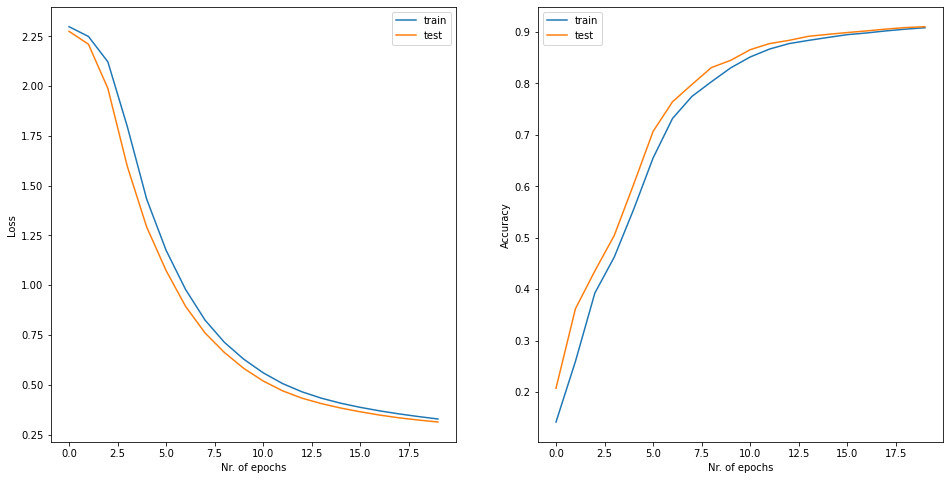

In [18]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_henormal_sigmoid"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.HeNormal(), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 2s 896us/step - loss: 0.9678 - accuracy: 0.7000 - val_loss: 0.2697 - val_accuracy: 0.9215
Epoch 2/20
1875/1875 [==============================] - 1s 776us/step - loss: 0.2594 - accuracy: 0.9235 - val_loss: 0.2068 - val_accuracy: 0.9411
Epoch 3/20
1875/1875 [==============================] - 1s 781us/step - loss: 0.1987 - accuracy: 0.9416 - val_loss: 0.1711 - val_accuracy: 0.9505
Epoch 4/20
1875/1875 [==============================] - 1s 794us/step - loss: 0.1633 - accuracy: 0.9530 - val_loss: 0.1559 - val_accuracy: 0.9540
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1420 - accuracy: 0.9596 - val_loss: 0.1429 - val_accuracy: 0.9571
Epoch 6/20
1875/1875 [==============================] - 2s 905us/step - loss: 0.1259 - accuracy: 0.9638 - val_loss: 0.1320 - val_accuracy: 0.9617
Epoch 7/20
1875/1875 [==============================] - 2s 916us/step - loss: 0.1170 - accuracy: 0.9660 - val_loss: 0.1215 - v

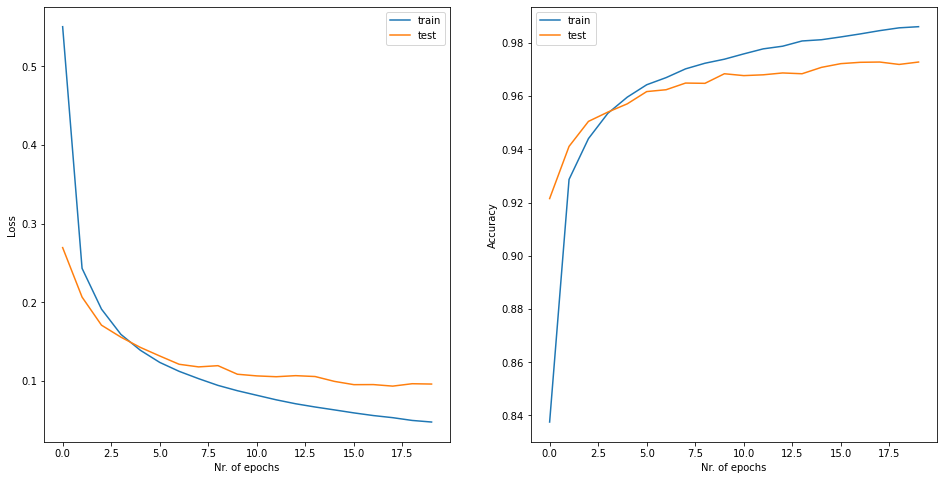

In [19]:
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_henormal_relu"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.HeNormal(), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### OUTPUTs

Provide here suitable plots and comments:

* Comparison of the different learning curves: 
    * train accuracy vs epochs for different models
    * train loss vs epochs for different models
    * test accuracy vs epochs for different models
    * test loss vs epochs for different models
    
Interpret the result and report your findings: Is it consistent with what you have learned in the lecture?

Are there ways (e.g. change in model) so that the effects of parameter initialisation become more clear?

##### Conclusion from the plots above
original: (default initialization for weights/bias and sigmoid function)
2 epochs = 15%
10 epochs = 75%
20 epochs = 88%

zero/sigmoid:
useless

zero/relu:
useless

glorotnormal/sigmoid:
same performance as original. (90% by the end)
Is glorothnormal the default?

glorothnormal/relu:
very steep learning curve (after epoch 2 alread better than glorotnormal/sigmoid with 20 epochs)
higher performance than the original. (96% by the end)

RandomNormal/sigmoid:
learn faster in the beginning as the original (steep learning curve), but results in a lower performance of around 83% in the end.

randomnormal/relu:
learns slower (in terms of steepness of the accuracy curve) than the original and has a lower overall performance of 73% after 20 epochs. On top of that, the accuracy of the test-set is very wiggly.

HeNormal/sigmoid:
steeper than the original version.
converges very fast after ~10 epochs.
This results in a performance of ~90% after 20 epochs, which is roughly equal to the default model.

HeNormal/relu:
Very steep learning curve.
Relative high performance after a low number of epochs. (5 epochs = ~95%)
Very good performance after 20 epochs (96-97%)

The two versions glorothnormal/relu and HeNormal/relu are by far the fastest learning models with the highest accuracy (~95%) after 20 epochs.

### Batch Normalisation

* No regularisation
* __Batch Norm__: with / without 
* __Parameter Initialisation: Random Normal (0,1), GlorotNormal__
* __Activation: Compare Sigmoid, ReLu__
* SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop).

Run with/without batchnorm in combination with sigmoid or relu (with GlorotNormal).<br>
Run with/without batchnorm in combination with GlorotNormal or RandomNormal (with sigmoid).<br>
Hence run 8 different models.

In [20]:
def model_batchnorm(layersizes, initializer, activation):
    """
    Provides an MLP model (using Sequential) with given layersizes. The last layer is a softmax layer.
    As activation function use sigmoid.
        
    Arguments:
    layersizes -- list of integers with the number of hidden units per layer. The last element is for MNIST 10.
    initializer -- weight initializer
    activation -- string specifying the activation function to be used.
    """
    ### START YOUR CODE HERE ###

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    
    model.add(tf.keras.layers.Dense(units=layersizes[0],
                                    use_bias=True,
                                    activation=activation,
                                    name='Layer_{}'.format(0)))
    model.add(tf.keras.layers.BatchNormalization())
    
    for i, ls in enumerate(layersizes[1:-1]):
        model.add(tf.keras.layers.Dense(units=ls,
                                        use_bias=True,
                                        activation=activation,
                                        name='Layer_{}'.format(i+1)))
        model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.Dense(units=layersizes[-1],
                                    use_bias=True,
                                    activation='softmax',
                                    name='Layer_{}'.format(len(layersizes)-1)))

    ### STOP YOUR CODE HERE ###

    return model

#### Run model

Run the different variants.

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 2.8585 - accuracy: 0.1809 - val_loss: 1.7748 - val_accuracy: 0.4010
Epoch 2/20
1875/1875 [==============================] - 1s 767us/step - loss: 1.6684 - accuracy: 0.4460 - val_loss: 1.3933 - val_accuracy: 0.5419
Epoch 3/20
1875/1875 [==============================] - 2s 889us/step - loss: 1.3394 - accuracy: 0.5606 - val_loss: 1.1835 - val_accuracy: 0.6121
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.1520 - accuracy: 0.6236 - val_loss: 1.0500 - val_accuracy: 0.6579
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.0316 - accuracy: 0.6629 - val_loss: 0.9556 - val_accuracy: 0.6876
Epoch 6/20
1875/1875 [==============================] - 2s 974us/step - loss: 0.9398 - accuracy: 0.6927 - val_loss: 0.8818 - val_accuracy: 0.7125
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.8673 - accuracy: 0.7203 - val_loss: 0.8238 - val_acc

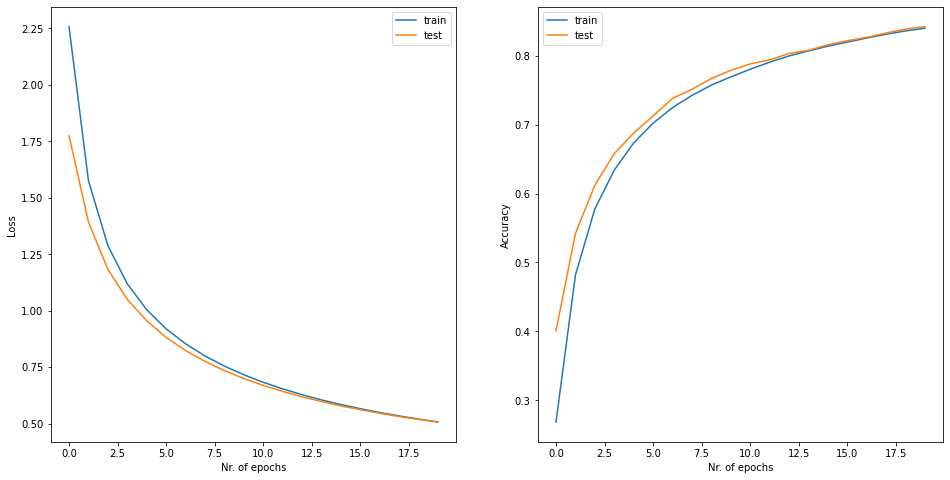

In [21]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_randomnormal_sigmoid_pi"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.RandomNormal(mean=0, stddev=1), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6790 - accuracy: 0.7960 - val_loss: 0.2889 - val_accuracy: 0.9168
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3342 - accuracy: 0.9015 - val_loss: 0.2528 - val_accuracy: 0.9241
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2885 - accuracy: 0.9154 - val_loss: 0.2194 - val_accuracy: 0.9359
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2538 - accuracy: 0.9250 - val_loss: 0.1984 - val_accuracy: 0.9425
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2258 - accuracy: 0.9343 - val_loss: 0.1811 - val_accuracy: 0.9457
Epoch 6/20
1875/1875 [==============================] - 2s 969us/step - loss: 0.1974 - accuracy: 0.9420 - val_loss: 0.1667 - val_accuracy: 0.9512
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1848 - accuracy: 0.9442 - val_loss: 0.1535 - val_accurac

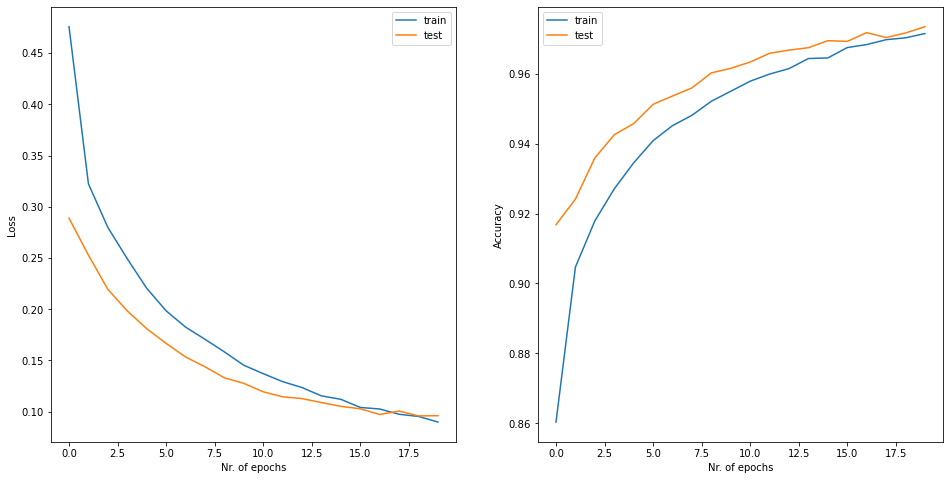

In [22]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_randomnormal_sigmoid_bn"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_batchnorm(layersizes, tf.keras.initializers.RandomNormal(mean=0, stddev=1), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs)

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 2.3168 - accuracy: 0.1158 - val_loss: 2.2920 - val_accuracy: 0.1155
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2895 - accuracy: 0.1468 - val_loss: 2.2766 - val_accuracy: 0.2493
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2711 - accuracy: 0.2130 - val_loss: 2.2425 - val_accuracy: 0.3029
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2239 - accuracy: 0.2921 - val_loss: 2.1235 - val_accuracy: 0.3303
Epoch 5/20
1875/1875 [==============================] - 1s 790us/step - loss: 2.0667 - accuracy: 0.3381 - val_loss: 1.8537 - val_accuracy: 0.3871
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.7810 - accuracy: 0.4296 - val_loss: 1.5262 - val_accuracy: 0.5138
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.4552 - accuracy: 0.5310 - val_loss: 1.2440 - val_accurac

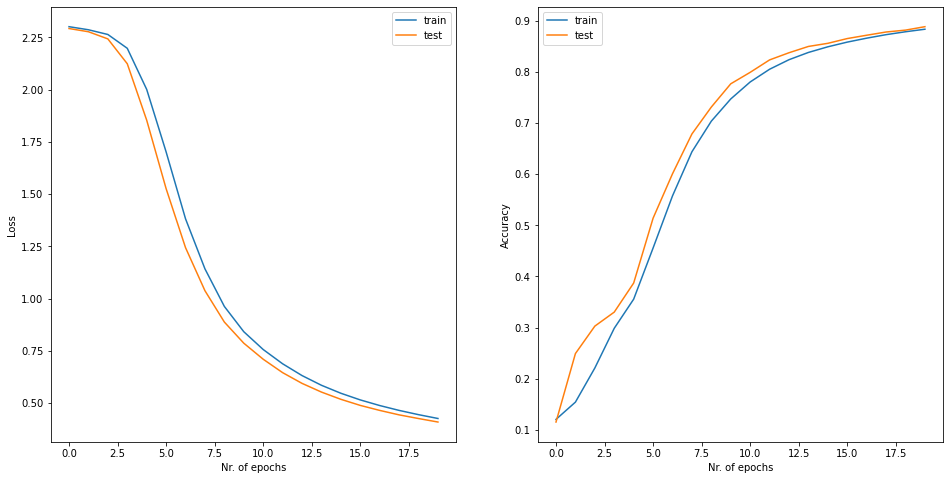

In [23]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_glorotnormal_sigmoid_pi"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6542 - accuracy: 0.8049 - val_loss: 0.2897 - val_accuracy: 0.9171
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3337 - accuracy: 0.9024 - val_loss: 0.2430 - val_accuracy: 0.9305
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2832 - accuracy: 0.9197 - val_loss: 0.2225 - val_accuracy: 0.9352
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2570 - accuracy: 0.9257 - val_loss: 0.1922 - val_accuracy: 0.9439
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2155 - accuracy: 0.9362 - val_loss: 0.1715 - val_accuracy: 0.9495
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2017 - accuracy: 0.9397 - val_loss: 0.1549 - val_accuracy: 0.9535
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1815 - accuracy: 0.9464 - val_loss: 0.1479 - val_accuracy:

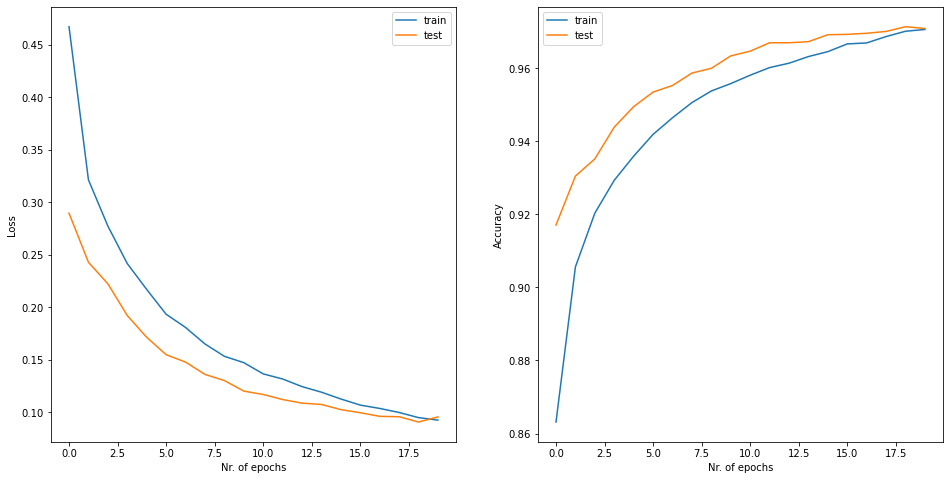

In [24]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_glorotnormal_sigmoid_bn"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_batchnorm(layersizes, tf.keras.initializers.GlorotNormal(), 'sigmoid')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

Epoch 1/20
1875/1875 [==============================] - 2s 963us/step - loss: 28.2737 - accuracy: 0.1356 - val_loss: 2.2099 - val_accuracy: 0.1569
Epoch 2/20
1875/1875 [==============================] - 2s 800us/step - loss: 2.2153 - accuracy: 0.1523 - val_loss: 2.1792 - val_accuracy: 0.1602
Epoch 3/20
1875/1875 [==============================] - 2s 880us/step - loss: 2.1792 - accuracy: 0.1624 - val_loss: 2.1817 - val_accuracy: 0.1579
Epoch 4/20
1875/1875 [==============================] - 2s 812us/step - loss: 2.1713 - accuracy: 0.1644 - val_loss: 2.1601 - val_accuracy: 0.1673
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1472 - accuracy: 0.1703 - val_loss: 2.1380 - val_accuracy: 0.1814
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 2.1325 - accuracy: 0.1805 - val_loss: 2.1317 - val_accuracy: 0.1782
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1134 - accuracy: 0.1846 - val_loss: 2.0986 - val_

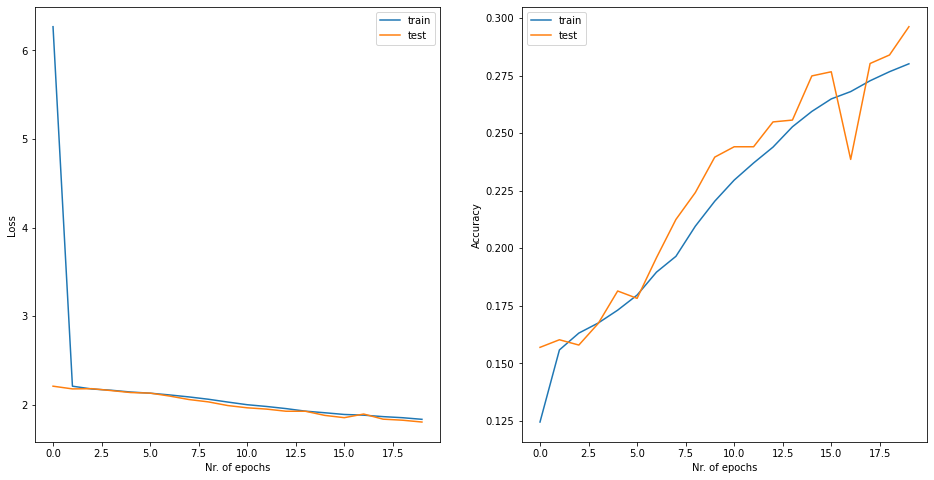

In [25]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_randomnormal_relu_pi"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.RandomNormal(mean=0, stddev=1), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7567 - accuracy: 0.7709 - val_loss: 0.2104 - val_accuracy: 0.9398
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2424 - accuracy: 0.9285 - val_loss: 0.1617 - val_accuracy: 0.9517
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1943 - accuracy: 0.9438 - val_loss: 0.1433 - val_accuracy: 0.9562
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1653 - accuracy: 0.9505 - val_loss: 0.1296 - val_accuracy: 0.9592
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1413 - accuracy: 0.9563 - val_loss: 0.1144 - val_accuracy: 0.9638
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1246 - accuracy: 0.9609 - val_loss: 0.1083 - val_accuracy: 0.9671
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1166 - accuracy: 0.9645 - val_loss: 0.1083 - val_accuracy:

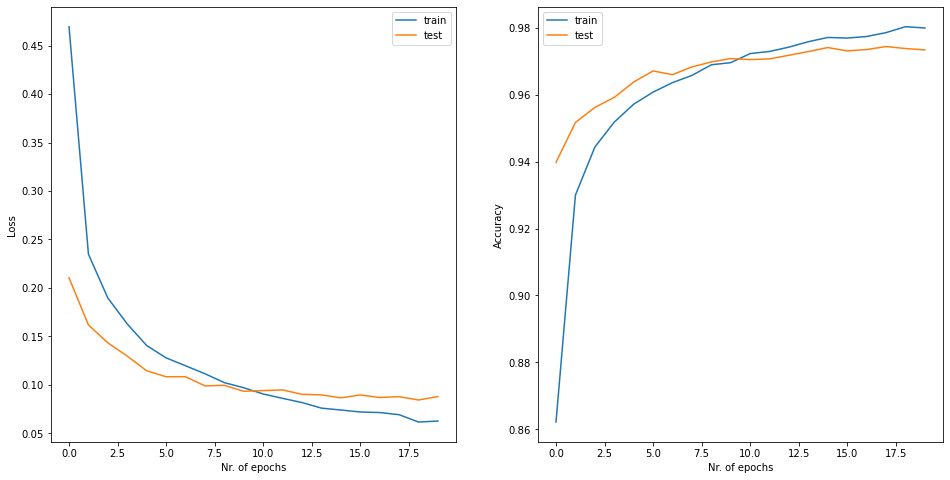

In [26]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_randomnormal_relu_bn"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_batchnorm(layersizes, tf.keras.initializers.RandomNormal(mean=0, stddev=1), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 1.3498 - accuracy: 0.5793 - val_loss: 0.3429 - val_accuracy: 0.8967
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3357 - accuracy: 0.9028 - val_loss: 0.2753 - val_accuracy: 0.9151
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2510 - accuracy: 0.9255 - val_loss: 0.2238 - val_accuracy: 0.9328
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2155 - accuracy: 0.9368 - val_loss: 0.1886 - val_accuracy: 0.9444
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1881 - accuracy: 0.9459 - val_loss: 0.1701 - val_accuracy: 0.9466
Epoch 6/20
1875/1875 [==============================] - 1s 778us/step - loss: 0.1629 - accuracy: 0.9523 - val_loss: 0.1508 - val_accuracy: 0.9551
Epoch 7/20
1875/1875 [==============================] - 2s 901us/step - loss: 0.1428 - accuracy: 0.9591 - val_loss: 0.1378 - val_accur

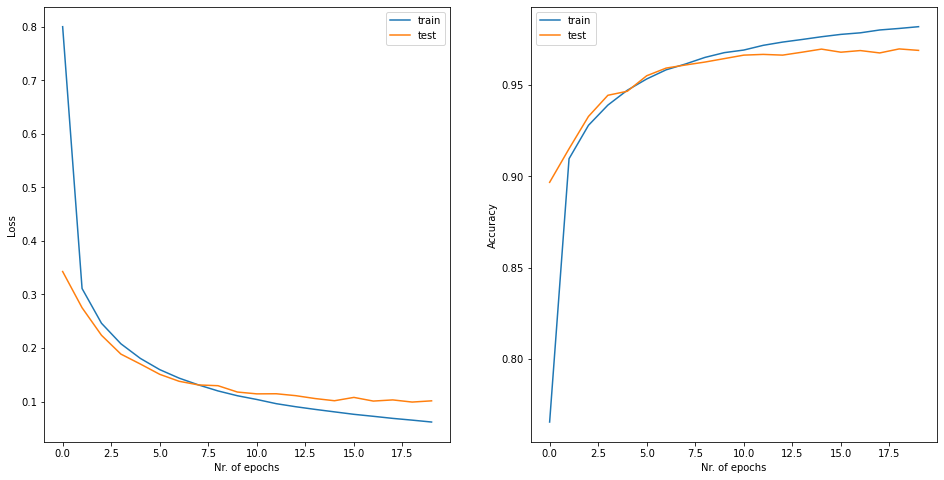

In [27]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_glorotnormal_relu_pi"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6882 - accuracy: 0.7926 - val_loss: 0.1985 - val_accuracy: 0.9435
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2417 - accuracy: 0.9278 - val_loss: 0.1535 - val_accuracy: 0.9553
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1955 - accuracy: 0.9412 - val_loss: 0.1396 - val_accuracy: 0.9590
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1678 - accuracy: 0.9503 - val_loss: 0.1222 - val_accuracy: 0.9633
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1468 - accuracy: 0.9557 - val_loss: 0.1133 - val_accuracy: 0.9652
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1354 - accuracy: 0.9586 - val_loss: 0.1067 - val_accuracy: 0.9672
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1184 - accuracy: 0.9631 - val_loss: 0.0998 - val_accuracy:

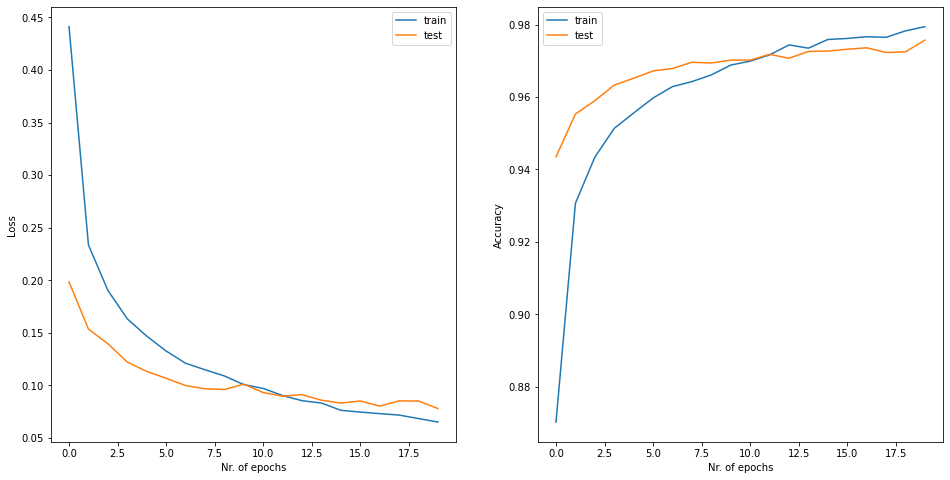

In [28]:
### START YOUR CODE HERE ###
# this duplicated code could be defined in a function, but I am too lazy right now...
run_name = "run_glorotnormal_relu_bn"
rundir = os.path.join(outdir, run_name)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=rundir, histogram_freq=1, profile_batch=0)

# fit model
model = model_batchnorm(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer="sgd",
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
### STOP YOUR CODE HERE ###

#### OUTPUTs

Provide here suitable plots and comments:

* Comparison of the different learning curves: 
    * train accuracy vs epochs for different models
    * train loss vs epochs for different models
    * test accuracy vs epochs for different models
    * test loss vs epochs for different models
    
* Inspect the histograms of the activations and compare them for the different models.

* Find the max learning rate for the model with and without Batch Norm. 

Interpret the result and report your findings: Is it consistent with what you have learned in the lecture?

Are there ways (e.g. change in model) so that the effects of batch norm become more clear?

##### Notes:
- The effects of using Batch Norm are quite consistent with what we've learned, especially in speeding up the convergence. It is also noticeable in Tensorboard that it is less dependence with the activation functions.
- In our model, the effect of batch norm become clearer if we compare it with batch normalization in three steps (affine-bn-activation).

### Optimizers

* No regularisation
* No BatchNorm 
* Parameter Initialisation: GlorotNormal
* Activation: ReLu
* Optimizers: Compare 
    * SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop)
    * RmsProp
    * Momentum

Create an according model and train it with the different optimizers.

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5891 - accuracy: 0.8111 - val_loss: 0.1614 - val_accuracy: 0.9533
Epoch 2/20
1875/1875 [==============================] - 2s 978us/step - loss: 0.1539 - accuracy: 0.9540 - val_loss: 0.1352 - val_accuracy: 0.9606
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1106 - accuracy: 0.9664 - val_loss: 0.1508 - val_accuracy: 0.9547
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0909 - accuracy: 0.9724 - val_loss: 0.1084 - val_accuracy: 0.9679
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0750 - accuracy: 0.9763 - val_loss: 0.1068 - val_accuracy: 0.9695
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0665 - accuracy: 0.9789 - val_loss: 0.1055 - val_accuracy: 0.9669
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0616 - accuracy: 0.9805 - val_loss: 0.0960 - val_accurac

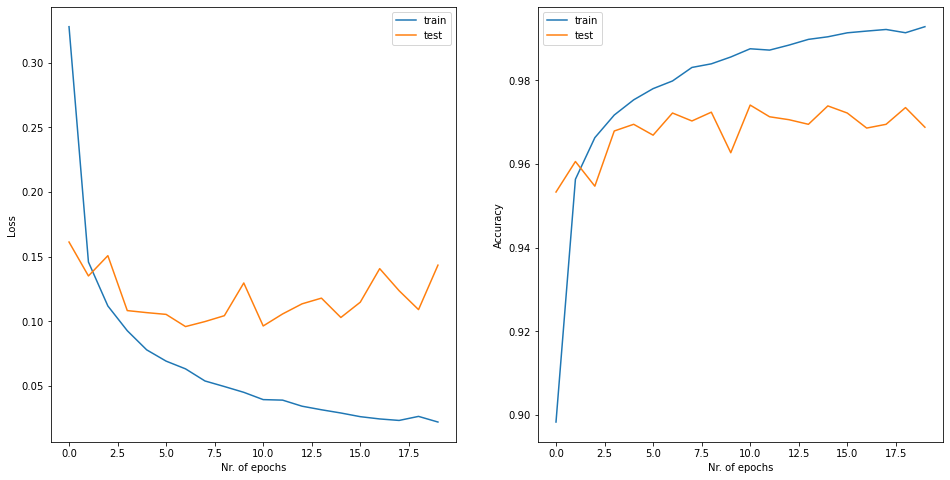

In [29]:
# this duplicated code could be defined in a function, but I am too lazy right now...

# fit model (SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop))
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer=tf.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs)

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6221 - accuracy: 0.8019 - val_loss: 0.1740 - val_accuracy: 0.9468
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1510 - accuracy: 0.9532 - val_loss: 0.1273 - val_accuracy: 0.9608
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1072 - accuracy: 0.9664 - val_loss: 0.1340 - val_accuracy: 0.9570
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0904 - accuracy: 0.9721 - val_loss: 0.1083 - val_accuracy: 0.9688
Epoch 5/20
1875/1875 [==============================] - 2s 923us/step - loss: 0.0728 - accuracy: 0.9769 - val_loss: 0.1178 - val_accuracy: 0.9647
Epoch 6/20
1875/1875 [==============================] - 2s 901us/step - loss: 0.0669 - accuracy: 0.9788 - val_loss: 0.0942 - val_accuracy: 0.9724
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0557 - accuracy: 0.9822 - val_loss: 0.0990 - val_accur

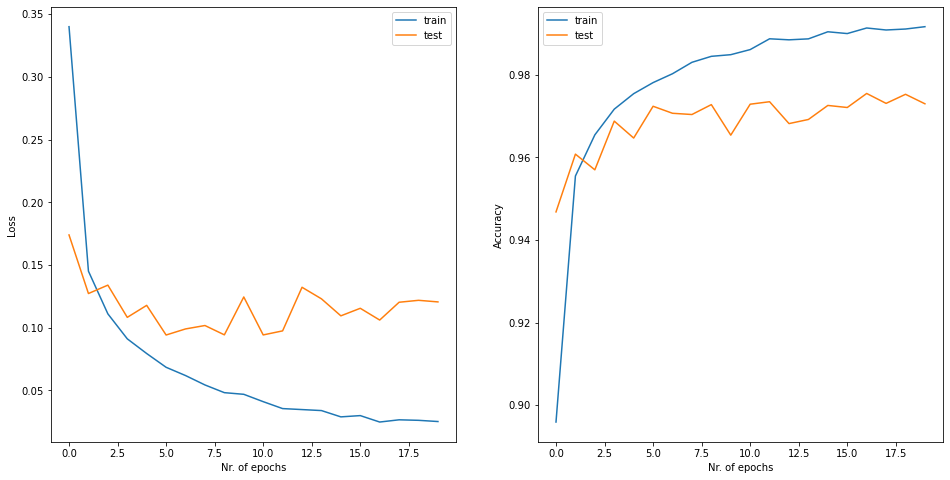

In [30]:
# this duplicated code could be defined in a function, but I am too lazy right now...

# fit model (RMS prop)
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs)

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 2s 986us/step - loss: 0.5948 - accuracy: 0.8108 - val_loss: 0.1793 - val_accuracy: 0.9448
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1541 - accuracy: 0.9520 - val_loss: 0.1268 - val_accuracy: 0.9612
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1132 - accuracy: 0.9654 - val_loss: 0.1174 - val_accuracy: 0.9651
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0879 - accuracy: 0.9722 - val_loss: 0.1066 - val_accuracy: 0.9664
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0749 - accuracy: 0.9764 - val_loss: 0.1071 - val_accuracy: 0.9684
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0673 - accuracy: 0.9781 - val_loss: 0.0947 - val_accuracy: 0.9739
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0570 - accuracy: 0.9817 - val_loss: 0.1160 - val_accurac

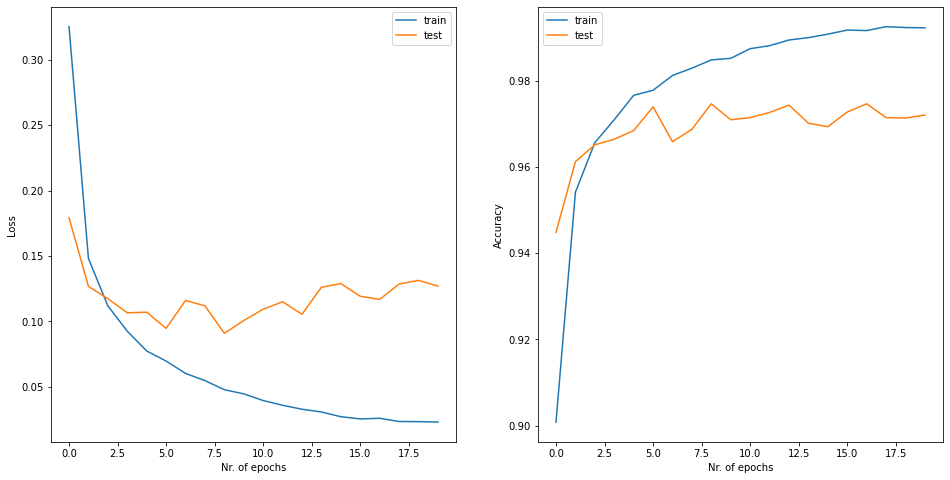

In [31]:
# this duplicated code could be defined in a function, but I am too lazy right now...

# fit model (RMS prop + Nesterov - Trying just for fun)
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs)

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1699.2931 - accuracy: 0.1035 - val_loss: 2.3400 - val_accuracy: 0.1010
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.4246 - accuracy: 0.1001 - val_loss: 2.3812 - val_accuracy: 0.1009
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3830 - accuracy: 0.1008 - val_loss: 2.3992 - val_accuracy: 0.1010
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3825 - accuracy: 0.1018 - val_loss: 2.3558 - val_accuracy: 0.0958
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3833 - accuracy: 0.1013 - val_loss: 2.3822 - val_accuracy: 0.0980
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3825 - accuracy: 0.1016 - val_loss: 2.4000 - val_accuracy: 0.1135
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 2.3844 - accuracy: 0.1010 - val_loss: 2.3599 - val_accura

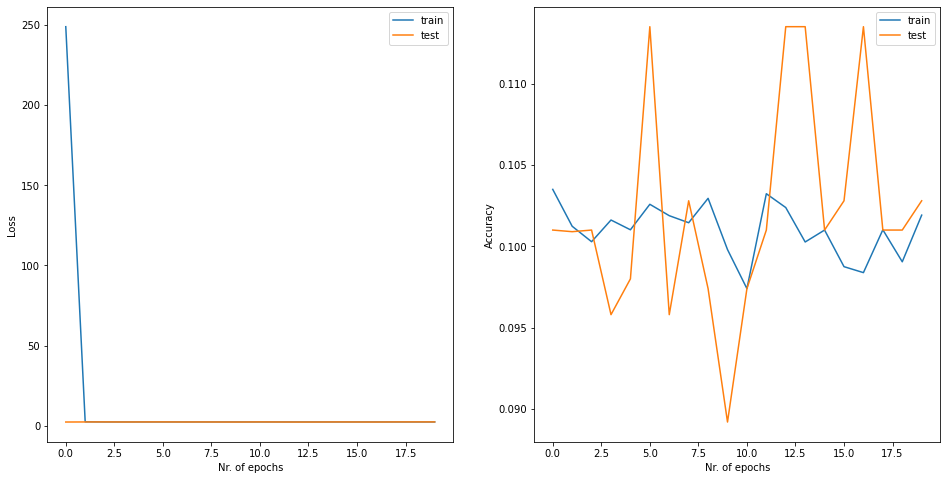

In [32]:
# this duplicated code could be defined in a function, but I am too lazy right now...

# fit model (RMS prop + Momentum)
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.5),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs)

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch 1/20
1875/1875 [==============================] - 2s 922us/step - loss: 1.3227 - accuracy: 0.5885 - val_loss: 0.3233 - val_accuracy: 0.9063
Epoch 2/20
1875/1875 [==============================] - 2s 885us/step - loss: 0.3040 - accuracy: 0.9119 - val_loss: 0.2452 - val_accuracy: 0.9298
Epoch 3/20
1875/1875 [==============================] - 2s 895us/step - loss: 0.2392 - accuracy: 0.9309 - val_loss: 0.2108 - val_accuracy: 0.9390
Epoch 4/20
1875/1875 [==============================] - 2s 877us/step - loss: 0.2061 - accuracy: 0.9414 - val_loss: 0.1903 - val_accuracy: 0.9454
Epoch 5/20
1875/1875 [==============================] - 2s 902us/step - loss: 0.1811 - accuracy: 0.9479 - val_loss: 0.1770 - val_accuracy: 0.9502
Epoch 6/20
1875/1875 [==============================] - 2s 899us/step - loss: 0.1656 - accuracy: 0.9513 - val_loss: 0.1565 - val_accuracy: 0.9557
Epoch 7/20
1875/1875 [==============================] - 2s 849us/step - loss: 0.1524 - accuracy: 0.9558 - val_loss: 0.1485 -

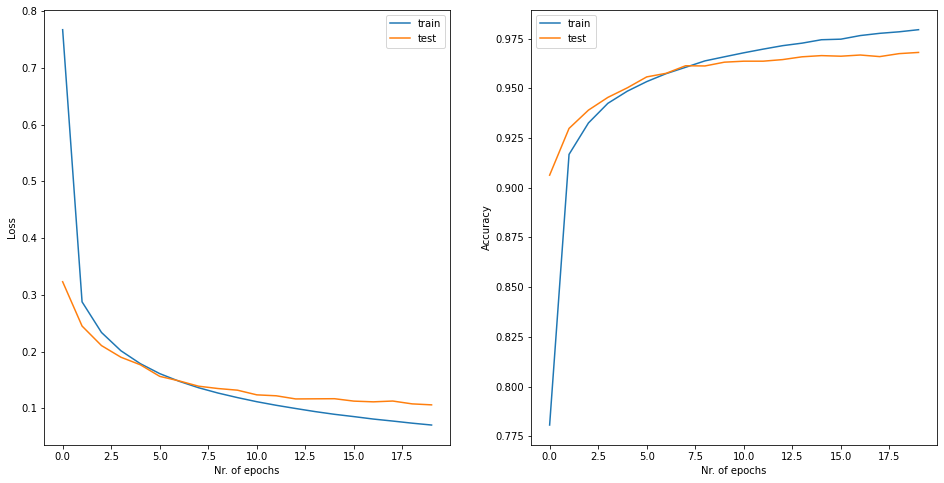

In [33]:
# this duplicated code could be defined in a function, but I am too lazy right now...

# fit model (Adam -state of the art - just for fun)
model = model_param_init(layersizes, tf.keras.initializers.GlorotNormal(), 'relu')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001*learning_rate),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batchsize,
                    epochs=epochs)

# plot
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Nr. of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### OUTPUTs

TODO: 
* Comparison of the different learning curves: 
    * train accuracy vs epochs for optimizers
    * train loss vs epochs for optimizers
    * test accuracy vs epochs for optimizers
    * test loss vs epochs for optimizers
    
Interpret the result and report your findings: Is it consistent with what you have learned in the lecture?

Are there ways (e.g. change in model) so that the effects of the different optimizers become more clear?

##### Conclusion
###### SGD with given batchsize and learning rate, no accelerators (no momentum nor RMS prop)
- Overall very nice results
- Steep descending loss function, which is converging towards 0
- Steep ascending accuracy function, which is converging towards 97% after 20 epochs.

###### RmsProp
- Overall very nice curves
- Super steep learning curve, which converges relativly fast to around 97% after 7-20 epochs

###### RMS prop + Nesterov
- Overall very nice curves
- Super steep learning curve, which converges relativly fast to around 97% after 3-20 epochs
- Nesterov has speed up the training, so the validation curve does not improve after ~3-4 epochs

###### RMS prop + Momentum
- Unusable curves
- Urgent need for better parameters.

###### Adam
- Overall best curves
- Very steep ascending learning curve in the first three epochs
- Converges to ~96% after 20 epochs
- Very smooth train/test curves -> Robust
